In [13]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import visdom
from common_net import *
import math
import sys 
from data_generator import *
#ffmpeg -start_number 0 -i disc_generated_samples_%05d.png -vcodec mpeg4 test.avi <- to create the video

In [14]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
opt={}
opt['batchSize']=4096
opt['dropout']=0.5
opt['ndres']=16
opt['ngres']=16
opt['ngf']=4
opt['ndf']=4
opt['out_dim']=1
opt['nz']=10
opt['ngpu']=1
opt['num_samples']=1000000
opt['outf']='./analysis_reduce_cor_resnet_gen_3/'
opt=dotdict(opt)

In [15]:
ngpu=int(opt.ngpu)
class _netG(nn.Module):
    def __init__(self,ngpu):
        super(_netG,self).__init__()
        self.ngpu=ngpu
        main_block=[]

        #Input is z going to series of rsidual blocks

        main_block+=[nn.Linear(opt.nz,opt.ngf) ]

        # Sets of residual blocks start

        for i in range(opt.ngres):
            main_block+= [ResBlock(opt.ngf,opt.dropout)] #[BATCHResBlock(opt.ngf,opt.dropout)]

        # Final layer to map to 1D

        main_block+=[nn.Linear(opt.ngf,opt.out_dim)]

        self.main=nn.Sequential(*main_block)


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = _netG(ngpu)

In [16]:
gen_path='reduce_cor_resnet_gen_3/netG_epoch_450.pth'
netG.load_state_dict(torch.load(gen_path))

In [17]:
netG.main

Sequential (
  (0): Linear (10 -> 4)
  (1): ResBlock (
    (model): Sequential (
      (0): Linear (4 -> 4)
      (1): ReLU (inplace)
      (2): Linear (4 -> 4)
      (3): Dropout (p = 0.5)
    )
  )
  (2): ResBlock (
    (model): Sequential (
      (0): Linear (4 -> 4)
      (1): ReLU (inplace)
      (2): Linear (4 -> 4)
      (3): Dropout (p = 0.5)
    )
  )
  (3): ResBlock (
    (model): Sequential (
      (0): Linear (4 -> 4)
      (1): ReLU (inplace)
      (2): Linear (4 -> 4)
      (3): Dropout (p = 0.5)
    )
  )
  (4): ResBlock (
    (model): Sequential (
      (0): Linear (4 -> 4)
      (1): ReLU (inplace)
      (2): Linear (4 -> 4)
      (3): Dropout (p = 0.5)
    )
  )
  (5): ResBlock (
    (model): Sequential (
      (0): Linear (4 -> 4)
      (1): ReLU (inplace)
      (2): Linear (4 -> 4)
      (3): Dropout (p = 0.5)
    )
  )
  (6): ResBlock (
    (model): Sequential (
      (0): Linear (4 -> 4)
      (1): ReLU (inplace)
      (2): Linear (4 -> 4)
      (3): Dropout (p = 

In [18]:
def forward_skip(netG,skip,inp):
    out=inp
    for i in range(len(netG.main)):
        if i in skip:
            continue
        layer=netG.main[i]
        out=layer.forward(out)
        
    return out

In [19]:
def forward_swap(netG,swap_pair,inp):
    out=inp
    for i in range(len(netG.main)):
        if i==swap_pair[0]:
            layer = netG.main[swap_pair[1]]
        elif i==swap_pair[1]:        
            layer = netG.main[swap_pair[0]]
        else:
            layer=netG.main[i]
        
        out=layer.forward(out)
        
    return out

In [20]:
try:
    os.makedirs(opt.outf)
except OSError:
    pass

In [21]:
dataset=MoG1DDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,shuffle=True, num_workers=2)
generated_samples=np.zeros(opt.num_samples)
noise = torch.FloatTensor(opt.batchSize, opt.nz)
noise=noise.cuda()
netG.cuda()

_netG (
  (main): Sequential (
    (0): Linear (10 -> 4)
    (1): ResBlock (
      (model): Sequential (
        (0): Linear (4 -> 4)
        (1): ReLU (inplace)
        (2): Linear (4 -> 4)
        (3): Dropout (p = 0.5)
      )
    )
    (2): ResBlock (
      (model): Sequential (
        (0): Linear (4 -> 4)
        (1): ReLU (inplace)
        (2): Linear (4 -> 4)
        (3): Dropout (p = 0.5)
      )
    )
    (3): ResBlock (
      (model): Sequential (
        (0): Linear (4 -> 4)
        (1): ReLU (inplace)
        (2): Linear (4 -> 4)
        (3): Dropout (p = 0.5)
      )
    )
    (4): ResBlock (
      (model): Sequential (
        (0): Linear (4 -> 4)
        (1): ReLU (inplace)
        (2): Linear (4 -> 4)
        (3): Dropout (p = 0.5)
      )
    )
    (5): ResBlock (
      (model): Sequential (
        (0): Linear (4 -> 4)
        (1): ReLU (inplace)
        (2): Linear (4 -> 4)
        (3): Dropout (p = 0.5)
      )
    )
    (6): ResBlock (
      (model): Sequential (


In [22]:
# skip 1 layer
for to_skip in xrange(1,opt.ngres+1):
    num_sampled=0
    while(num_sampled<opt.num_samples):
        noise.resize_(opt.batchSize, opt.nz).normal_(0, 1)
        noisev = Variable(noise)
        fake = forward_skip(netG,[to_skip],noisev)
        fake_cpu_np=fake.data.cpu().numpy().reshape(opt.batchSize)
        if num_sampled+opt.batchSize<opt.num_samples:
            generated_samples[num_sampled:num_sampled+opt.batchSize ] = fake_cpu_np
        else:
            generated_samples[num_sampled:opt.num_samples] = fake_cpu_np[ 0:opt.num_samples-num_sampled ]
        num_sampled+=opt.batchSize
    file_num= '{0:05d}'.format(to_skip)
    dataset.plot_generated_samples(generated_samples,filename=opt.outf+'remove_1_generated_samples_'+ file_num +'.png')

In [23]:
# skip 2 layers
for to_skip in xrange(1,opt.ngres):
    num_sampled=0
    while(num_sampled<opt.num_samples):
        noise.resize_(opt.batchSize, opt.nz).normal_(0, 1)
        noisev = Variable(noise)
        fake = forward_skip(netG,[to_skip,to_skip+1],noisev)
        fake_cpu_np=fake.data.cpu().numpy().reshape(opt.batchSize)
        if num_sampled+opt.batchSize<opt.num_samples:
            generated_samples[num_sampled:num_sampled+opt.batchSize ] = fake_cpu_np
        else:
            generated_samples[num_sampled:opt.num_samples] = fake_cpu_np[ 0:opt.num_samples-num_sampled ]
        num_sampled+=opt.batchSize
    file_num= '{0:05d}'.format(to_skip)
    dataset.plot_generated_samples(generated_samples,filename=opt.outf+'remove_2_generated_samples_'+ file_num +'.png')

In [24]:
# swap 2 layers
for to_skip in xrange(1,opt.ngres-1):
    num_sampled=0
    while(num_sampled<opt.num_samples):
        noise.resize_(opt.batchSize, opt.nz).normal_(0, 1)
        noisev = Variable(noise)
        swap = np.random.randint(to_skip,opt.ngres)
        fake = forward_swap(netG,(to_skip,swap),noisev)
        fake_cpu_np=fake.data.cpu().numpy().reshape(opt.batchSize)
        if num_sampled+opt.batchSize<opt.num_samples:
            generated_samples[num_sampled:num_sampled+opt.batchSize ] = fake_cpu_np
        else:
            generated_samples[num_sampled:opt.num_samples] = fake_cpu_np[ 0:opt.num_samples-num_sampled ]
        num_sampled+=opt.batchSize
    file_num= '{0:05d}'.format(to_skip) + '{0:05d}'.format(swap)
    dataset.plot_generated_samples(generated_samples,filename=opt.outf+'swap_2_generated_samples_'+ file_num +'.png')

In [79]:
# testing the 2 disconnected swissroll dataset to mimic the problem of modeling a generative distribution of discontinuous manifolds
from sklearn.datasets.samples_generator import make_swiss_roll

n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise)

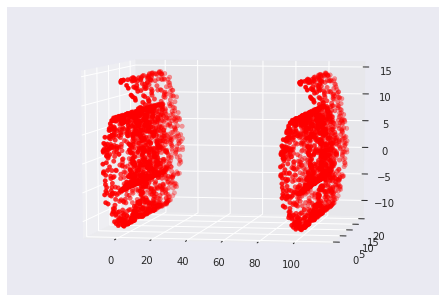

In [87]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)

ax.scatter(X[:, 0], X[:, 1], X[:, 2],color='red')

ax.scatter(X[:, 0]+100, X[:, 1], X[:, 2],color='red')

In [82]:
X.shape

(1500, 3)

In [91]:
X[0]=X[0] + np.array([1,1,1])